In [2]:
# Import the libraries
from pystac.extensions.eo import EOExtension as eo
import pystac_client
import planetary_computer
from odc.stac import configure_rio, stac_load
import dask.distributed
import dask.utils
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
# Set up Dask client for parallel processing
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, client=client)

# Configure rio with dynamic resolution
resolution = 20
memory_limit = dask.utils.parse_bytes(client.cluster.workers[0].memory_manager.memory_limit)
SHRINK = 4
if memory_limit < dask.utils.parse_bytes("4G"):
    SHRINK = 8  # Adjust chunk size if memory is limited

resolution = resolution * SHRINK


In [ ]:
# Define the area of interest (AOI) for Lake Michigan
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [-88.2, 43.0],  # Lower-left corner
            [-86.1, 43.0],  # Lower-right corner
            [-86.1, 45.0],  # Upper-right corner
            [-88.2, 45.0],  # Upper-left corner
            [-88.2, 43.0],  # Closing the polygon
        ]
    ],
}

#  time span of 1 month
time_of_interest = "2021-07-01/2023-07-01"

# Query the catalog for the data
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest
)
items = list(search.items())
print(f"Returned {len(items)} Items")


Returned 101 Items


In [5]:
# Load the data from the catalog with dynamic chunking and handle missing data
xx = stac_load(
    items,
    chunks={"x": 1024 * SHRINK, "y": 1024 * SHRINK},  # Dynamically adjust chunk size
    patch_url=planetary_computer.sign,
    resolution=resolution,
    dtype="uint16",  # Handle missing data by marking nodata values
    nodata=0
)

# Display loaded data
print(f"Bands: {','.join(list(xx.data_vars))}")
display(xx)


Bands: AOT,B01,B02,B03,B04,B05,B06,B07,B08,B09,B11,B12,B8A,SCL,WVP,visual


<xarray.Dataset> Size: 9GB
Dimensions:      (y: 3874, x: 3873, time: 18)
Coordinates:
  * y            (y) float64 31kB 5e+06 5e+06 5e+06 ... 4.69e+06 4.69e+06
  * x            (x) float64 31kB 3e+05 3.001e+05 ... 6.097e+05 6.098e+05
    spatial_ref  int32 4B 32616
  * time         (time) datetime64[ns] 144B 2023-06-01T16:28:39.024000 ... 20...
Data variables: (12/16)
    AOT          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    B01          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    B02          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    B03          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    B04          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    B05          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    ...           ...
    B11          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    B12          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    B8A          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    SCL          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    WVP          (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>
    visual       (time, y, x) uint16 540MB dask.array<chunksize=(1, 3874, 3873), meta=np.ndarray>

In [6]:
# Function to convert data to float and handle missing nodata values
def to_float(xx, nodata_value=None):
    _xx = xx.astype("float32")  # Convert data to float32 for precision
    if nodata_value is None:
        nodata_value = _xx.attrs.pop("nodata", None)  # Fetch nodata value if exists
    if nodata_value is not None:
        return _xx.where(xx != nodata_value)  # Replace nodata with NaN
    return _xx

# Convert specific bands to float32 and handle missing data
b05 = to_float(xx.B05)  # Red-Edge band
b04 = to_float(xx.B04)  # Red band


In [7]:
# Calculate NDCI with small constant to avoid division by zero
ndci = (b05 - b04) / (b05 + b04 + 1e-6)

# Apply Min-Max normalization to scale NDCI between 0 and 1
ndci = (ndci - ndci.min()) / (ndci.max() - ndci.min())

# Display the calculated NDCI
display(ndci)


<xarray.DataArray (time: 18, y: 3874, x: 3873)> Size: 1GB
dask.array<truediv, shape=(18, 3874, 3873), dtype=float32, chunksize=(1, 3874, 3873), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 31kB 5e+06 5e+06 5e+06 ... 4.69e+06 4.69e+06
  * x            (x) float64 31kB 3e+05 3.001e+05 ... 6.097e+05 6.098e+05
    spatial_ref  int32 4B 32616
  * time         (time) datetime64[ns] 144B 2023-06-01T16:28:39.024000 ... 20...

In [8]:
ndci = ndci.fillna(ndci.mean())

In [9]:
chl = 826.57*(ndci**3) - 176.43*(ndci**2) + 19*(ndci) + 4.071
display(chl)

<xarray.DataArray (time: 18, y: 3874, x: 3873)> Size: 1GB
dask.array<add, shape=(18, 3874, 3873), dtype=float32, chunksize=(1, 3874, 3873), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 31kB 5e+06 5e+06 5e+06 ... 4.69e+06 4.69e+06
  * x            (x) float64 31kB 3e+05 3.001e+05 ... 6.097e+05 6.098e+05
    spatial_ref  int32 4B 32616
  * time         (time) datetime64[ns] 144B 2023-06-01T16:28:39.024000 ... 20...

In [ ]:
#print(chl.min().values, chl.max().values)

4.071 673.211


In [11]:
client.close()

In [12]:
print(chl.values)

/Users/tishyakasliwal/anaconda3/envs/gdal_env/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


[[[ 90.86055   90.86055   90.86055  ...  90.86055   90.86055   90.86055 ]
  [ 90.86055   90.86055   90.86055  ... 124.44884  134.16101   90.86055 ]
  [ 90.86055   90.86055   90.86055  ... 125.090775 150.3232    90.86055 ]
  ...
  [ 90.86055   90.86055   90.86055  ... 135.58665  133.32443   90.86055 ]
  [ 90.86055   90.86055   90.86055  ... 137.33961  111.56047   90.86055 ]
  [ 90.86055   90.86055   90.86055  ...  90.86055   90.86055   90.86055 ]]

 [[ 90.86055   90.86055   90.86055  ...  90.86055   90.86055   90.86055 ]
  [ 81.07416  101.3986    98.18106  ...  90.86055   90.86055   90.86055 ]
  [ 91.48515   89.15215   88.477936 ...  90.86055   90.86055   90.86055 ]
  ...
  [ 90.86055   90.86055   90.86055  ...  90.86055   90.86055   90.86055 ]
  [ 90.86055   90.86055   90.86055  ...  90.86055   90.86055   90.86055 ]
  [ 90.86055   90.86055   90.86055  ...  90.86055   90.86055   90.86055 ]]

 [[ 90.86055   90.86055   90.86055  ...  90.86055   90.86055   90.86055 ]
  [ 90.86055   90.8605

In [7]:
# # Efficient concatenation of NDCI across the time dimension
# ndci_comp = xr.concat([ndci.isel(time=i) for i in range(len(ndci))], dim="time").compute()

# # Display concatenated time series
# print(ndci_comp)
# #WRONG

In [ ]:
# import dask.array as da

# # Ensure ndci is a Dask array
# ndci = ndci.chunk({"time": 1, "x": 1024, "y": 1024})

# # Concatenate using Dask arrays
# ndci_comp = da.concatenate([ndci.isel(time=i).data for i in range(ndci.sizes["time"])], axis=0)

# # Reshape the concatenated array to include the time dimension
# ndci_comp = ndci_comp.reshape((ndci.sizes["time"], ndci.sizes["y"], ndci.sizes["x"]))

# # Convert back to xarray DataArray
# ndci_comp = xr.DataArray(ndci_comp, dims=("time", "y", "x"), coords={"time": ndci.time, "y": ndci.y, "x": ndci.x})

# # Display concatenated time series
# print(ndci_comp)

<xarray.DataArray 'reshape-ce1218b16809268ee35c6ceaffdefabf' (time: 18,
                                                              y: 3874, x: 3873)> Size: 1GB
dask.array<reshape, shape=(18, 3874, 3873), dtype=float32, chunksize=(1, 969, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 144B 2023-06-01T16:28:39.024000 ... 2023-0...
  * y        (y) float64 31kB 5e+06 5e+06 5e+06 ... 4.69e+06 4.69e+06 4.69e+06
  * x        (x) float64 31kB 3e+05 3.001e+05 3.002e+05 ... 6.097e+05 6.098e+05


In [ ]:
#pip install netCDF4

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# import numpy as np
# import xarray as xr
# import dask.distributed

# # Restart the Dask client
# client = dask.distributed.Client()
# client.restart()

# # Load the saved NetCDF file
# ndci_comp = xr.open_dataarray("ndci_comp.nc")





2024-12-03 19:58:15,541 - distributed.nanny - WARNING - Restarting worker
2024-12-03 19:58:15,543 - distributed.nanny - WARNING - Restarting worker
2024-12-03 19:58:15,550 - distributed.nanny - WARNING - Restarting worker
2024-12-03 19:58:15,558 - distributed.nanny - WARNING - Restarting worker


In [ ]:
# # Interpolate NaN values along the time dimension
# ndci_comp_interpolated = ndci.interpolate_na(dim="time", method="linear")

# # Convert the Dask array to a NumPy array
# ndci_comp_np = ndci_comp_interpolated.compute()


# ndci_rechunked = ndci.chunk(dict(time=-1))
# ndci_comp_interpolated = ndci_rechunked.interpolate_na(dim="time", method="linear")

In [ ]:
# import numpy as np
# import xarray as xr
# import dask.distributed

# # Restart the Dask client
# client = dask.distributed.Client()
# client.restart()

# # Convert the Dask array to a NumPy array
# ndci_comp_np = ndci_comp_interpolated.compute()

In [ ]:
# Select a subset of coordinates (first 100 coordinates)
#ndci_subset = ndci[:, :100, :10]

In [13]:
# Select a subset of coordinates (first 100 coordinates)
chl_subset = chl[:, :100, :100]

In [14]:
print(chl_subset.shape)

(18, 100, 100)


In [ ]:
# chl_values = chl_subset.values.reshape(-1, 1)
# print(chl_values)

[[90.86055]
 [90.86055]
 [90.86055]
 ...
 [90.86055]
 [90.86055]
 [90.86055]]


In [ ]:
# display(chl_values)

array([[90.86055],
       [90.86055],
       [90.86055],
       ...,
       [90.86055],
       [90.86055],
       [90.86055]], dtype=float32)

In [ ]:
pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 10.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.9/29.9 MB 9.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# ndci_subset = ndci_subset.fillna(ndci.mean()) #fill Nans with mean values
# # Normalize the data
# scaler = MinMaxScaler()
# ndci_values = ndci_subset.values.reshape(-1, 1)


In [ ]:
#chl_scaled = scaler.fit_transform(chl_values).reshape(chl_subset.shape)

In [ ]:
#print(chl_scaled.shape)

(18, 10, 10)


In [16]:
# Define a function to prepare the time series data for LSTM
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Set time steps (e.g., using last 10 values to predict the next)
time_steps = 10
X, y = create_dataset(chl_subset, time_steps)

# Reshape the input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], chl_subset.shape[1] * chl_subset.shape[2]))
y = np.reshape(y, (y.shape[0], chl_subset.shape[1] * chl_subset.shape[2]))

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (8, 10, 10000), y shape: (8, 10000)


In [17]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (6, 10, 10000), y_train shape: (6, 10000)
X_test shape: (2, 10, 10000), y_test shape: (2, 10000)


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1]))

model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │     2,010,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10000)          │       510,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,540,400 (9.69 MB)

 Trainable params: 2,540,400 (9.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 9928.7627 - val_loss: 8216.8320
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 9920.6074 - val_loss: 8210.7207
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 9916.2305 - val_loss: 8204.1240
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 9912.0723 - val_loss: 8197.0801
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 9903.9287 - val_loss: 8189.6064


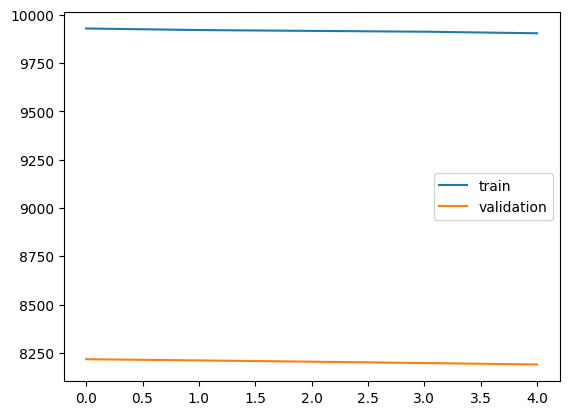

In [35]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()



In [36]:
# Evaluate the model
results = model.evaluate(X_test, y_test)
print(f"Model loss (MSE): {results}")
print("RMSE: ", np.sqrt(results))

# Make predictions
predictions = model.predict(X_test)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 12275.9268
Model loss (MSE): 12275.9267578125
RMSE:  110.7967813513213
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[0.30813292 0.36295468 0.3007446  ... 0.3679251  0.29534286 0.4109141 ]
 [0.30875123 0.363819   0.3011204  ... 0.36860877 0.29595613 0.41187036]]


In [24]:
print(y_test.min(), y_test.max())

69.09379 200.289


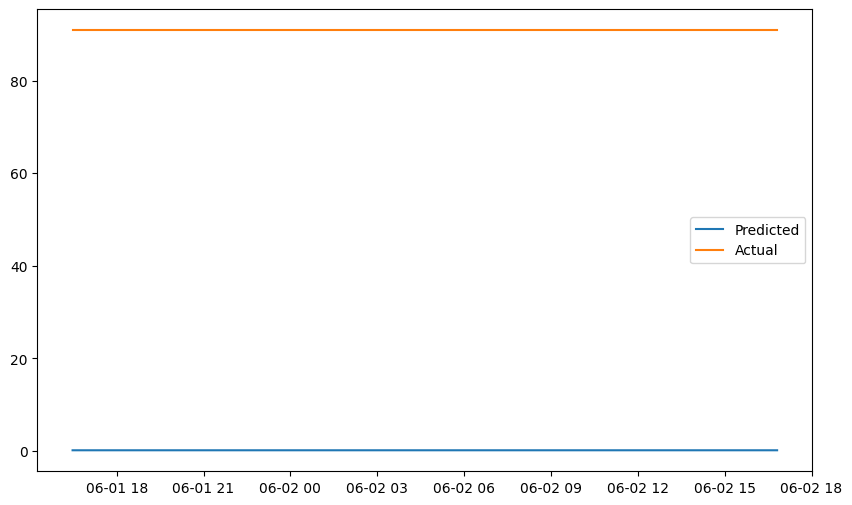

In [28]:
# Reshape predictions to the original shape
predictions = predictions.reshape((predictions.shape[0], chl_subset.shape[1], chl_subset.shape[2]))

# Inverse transform the predictions
#predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(predictions.shape)

# Calculate MSE
# y_test_reshaped = y_test.reshape(-1, 1)
# y_test_inverse = scaler.inverse_transform(y_test_reshaped).reshape(y_test.shape)
# mse = mean_squared_error(y_test_inverse, predictions.reshape(-1, 1))
# print(f"MSE: {mse}")

# Plot some predictions
plt.figure(figsize=(10, 6))
plt.plot(chl.coords['time'].values[:len(predictions)], predictions[:, 0, 0], label='Predicted')
plt.plot(chl.coords['time'].values[:len(predictions)], chl_subset[:len(predictions), 0, 0], label='Actual')
plt.legend()
plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# # Train the model
# history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# # Plot the training and validation loss
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='validation')
# plt.legend()
# plt.show()

# # Evaluate the model
# loss = model.evaluate(X_test, y_test)
# print(f"Model loss: {loss}")

# # Make predictions
# predictions = model.predict(X)
# print(predictions)
# # Reshape predictions to the original shape
# predictions = predictions.reshape((predictions.shape[0], chl_subset.shape[1], chl_subset.shape[2]))

# # Inverse transform the predictions
# predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(predictions.shape)

# # Plot some predictions
# plt.figure(figsize=(10, 6))
# plt.plot(chl.coords['time'].values[:len(predictions)], predictions[:, 0, 0], label='Predicted')
# plt.plot(chl.coords['time'].values[:len(predictions)], chl_subset[:len(predictions), 0, 0], label='Actual')
# plt.legend()
# plt.show()

In [ ]:
# # Check for NaN or infinite values in the data
# if np.isnan(ndci_comp_np_subset).any() or np.isinf(ndci_comp_np_subset).any():
#     raise ValueError("Input data contains NaN or infinite values.")
